In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift

In [2]:
%matplotlib widget
# makes plots interactive

In [3]:
%matplotlib inline

In [4]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [5]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [6]:
dx = 7.5 
dy = 7.5
dt = 1

In [7]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [8]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww, kk, th

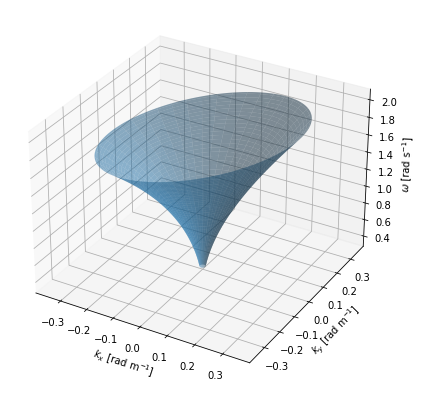

In [9]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww, kk, th = plot_disp_shell(axes, h=1000, z = z, U = U, psi = 0)

In [10]:
dk = 0.005
k1 = np.arange(0.01, 0.35, dk)

In [11]:
k1

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

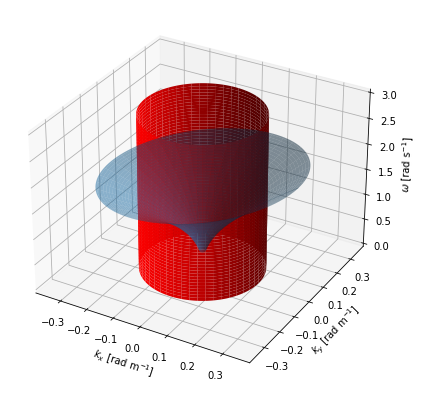

In [12]:
# Define the cylinder parameters
cut_k = 0.21
height = 3

# slice at k = 0.08

# Create data for the cylinder
theta = np.linspace(0, 2 * np.pi, 1000)
z_cylinder = np.linspace(0, height, 1000)
theta, z_cylinder = np.meshgrid(theta, z_cylinder)
x_cylinder = cut_k* np.cos(theta)
y_cylinder = cut_k* np.sin(theta)

# plot surface
fig = plt.figure(figsize=(7, 7))
axes = fig.add_subplot(111, projection='3d')
kx, ky, ww, kk, th = plot_disp_shell(axes, h=1000, z=z, U=U, psi=0)

# Plot cylinder
axes.plot_surface(x_cylinder, y_cylinder, z_cylinder, color='red', alpha=1)

plt.show()

In [13]:
def plot_disp_surf_at_angle(spec_theta, h, z, U, psi):

# (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww, kk, th = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]

    plt.plot(disp_r, disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation at $\Theta$")
    #plt.legend()
    
    return kx, ky, disp_r,disp_ww_for_theta

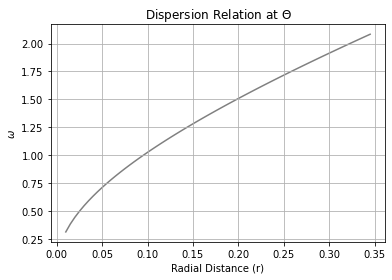

In [14]:
kx, ky, disp_r, disp_ww_for_theta = plot_disp_surf_at_angle(0, h = 1000, z=z, U=U, psi = 0)

In [15]:
y_interpolated = np.interp( cut_k, disp_r, disp_ww_for_theta)
y_interpolated

1.5513088047831167

In [16]:
angles_list = np.linspace(- np.pi,  np.pi, 100)

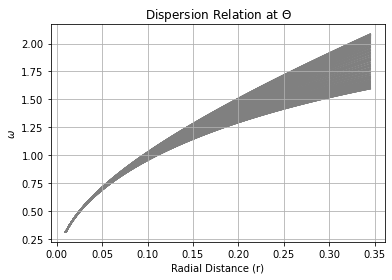

In [17]:
intersection_w_values = []

for i in range(len(angles_list)):
    kx, ky, disp_r, disp_ww_for_theta = plot_disp_surf_at_angle(angles_list[i], h = 1000, z=z, U=U, psi = 0)
    
    w_interpolate = np.interp( cut_k, disp_r, disp_ww_for_theta)
    
    intersection_w_values.append(w_interpolate)

Text(0.5, 1.0, 'Intersection surface')

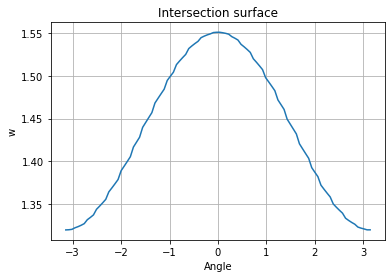

In [18]:
plt.plot(angles_list, intersection_w_values)
plt.grid(True)
plt.xlabel("Angle")
plt.ylabel("w")

plt.title("Intersection surface")

In [19]:
def cylinder_cross_section(Spectrum, dtheta, power_Spectrum_cut , order=None):
    if order is None:
        order = 4

    Kx_2D = np.squeeze(Kx_3D[0,:,:])
    Ky_2D = np.squeeze(Ky_3D[0,:,:])
    W_1D = np.squeeze(W_3D[:,0,0])

    theta_2D = np.arctan2(-Ky_2D, -Kx_2D)
    theta_3D = np.tile(theta_2D[:, :, np.newaxis], (1, 1, W_1D.size))

    theta_vals = np.arange(-np.pi, np.pi + dtheta, dtheta)
    S_cyl = np.zeros((W_1D.size, theta_vals.size))

    for ii in range(theta_vals.size):
        theta_diff = np.angle(np.exp(1j * theta_3D) * np.exp(-1j * theta_vals[ii]))
        theta_filt = np.exp(-2 * (theta_diff / dtheta) ** order)
        S_filt = power_Spectrum_cut.T * theta_filt
        S_cyl[:, ii] = np.nansum(S_filt, axis=(0, 1))

    thetaM, omegaM = np.meshgrid(theta_vals, W_1D)

    Scyl = {
        'P_k': S_cyl,
        'thetaM': thetaM,
        'omegaM': omegaM,
        'Kx_2D': Kx_2D, 
        'Ky_2D': Ky_2D,
        'W_1D': W_1D,
        'theta_2D':theta_2D,
        'theta_3D':theta_3D,
        'theta_vals':theta_vals,
        'theta_diff':theta_diff,
        'theta_filt':theta_filt
    }

    return Scyl

In [20]:
dtheta = 2*dk / cut_k

In [21]:
dk

0.005

In [22]:
dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
dk

0.012503851357571316

In [23]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

In [24]:
Kx = spec3d.kx
Ky = spec3d.ky
w = spec3d.w

# ?? difference is here 

In [25]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [26]:
dKx

0.012693303650867849

In [27]:
Norm = dKx * dKy * dW

In [28]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# power_Spectrum = spec3d.spectrum()

In [35]:
ind_x = np.abs(Kx) <= cut_k+dk
ind_y = np.abs(Ky) <= cut_k+dk
ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])
    
W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')
    
# Use np.ix_ for boolean indexing to extract the desired values
power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
power_Spectrum_cut[(K_3D < cut_k-dk) | (K_3D > cut_k+dk)] = np.nan
    
power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

In [37]:
np.nanmax(power_Spectrum_cut)

0.007938969320688327

In [38]:
Scyl = cylinder_cross_section( Spectrum , dtheta , power_Spectrum_cut, 4 );

In [39]:
Scyl

{'P_k': array([[2.53182451e-08, 6.84883313e-08, 7.84390692e-08, ...,
         2.59987298e-08, 1.88804193e-08, 2.59719624e-08],
        [2.52973015e-08, 6.87478784e-08, 7.88624691e-08, ...,
         2.60121162e-08, 1.88171194e-08, 2.59536966e-08],
        [2.52812613e-08, 6.90137258e-08, 7.92944149e-08, ...,
         2.60271864e-08, 1.87544833e-08, 2.59403848e-08],
        ...,
        [1.60981987e-08, 5.71371692e-08, 4.93495184e-08, ...,
         2.22642877e-08, 2.72111156e-08, 1.65540024e-08],
        [1.60236498e-08, 5.69007019e-08, 4.91452791e-08, ...,
         2.21410968e-08, 2.70575853e-08, 1.64775809e-08],
        [1.59498136e-08, 5.66667478e-08, 4.89434136e-08, ...,
         2.20194536e-08, 2.69058087e-08, 1.64018912e-08]]),
 'thetaM': array([[-3.14159265, -3.09397361, -3.04635456, ...,  3.04888354,
          3.09650258,  3.14412163],
        [-3.14159265, -3.09397361, -3.04635456, ...,  3.04888354,
          3.09650258,  3.14412163],
        [-3.14159265, -3.09397361, -3.046354

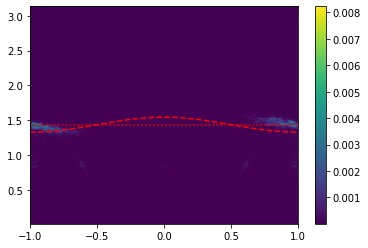

In [44]:
thetaVals = Scyl['thetaM'][0, :] / np.pi 
omegaM_values = Scyl['omegaM'][:, 0]

# Plotting
plt.imshow( Scyl['P_k'] , extent=[min(thetaVals) , max(thetaVals)  , min(omegaM_values), max(omegaM_values)],
        aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
    
plt.plot(thetaVals , np.sqrt(1) * np.sqrt(9.81 * cut_k) + 0 * thetaVals, linestyle=':', color='r', linewidth=1.5)
plt.plot(thetaVals , np.sqrt(1) * np.sqrt(9.81 * cut_k) + cut_k * (np.cos(thetaVals*np.pi) * (0.509567) + np.sin(thetaVals*np.pi) * 0),
        linestyle='--', color='r', linewidth=1.5)


plt.show()